In [1]:
import torch
import matplotlib.pyplot as plt
import random

#from IPython.testing.tools import full_path
from diffusers import ZImagePipeline

from nunchaku import NunchakuZImageTransformer2DModel
from nunchaku.utils import get_precision
import os


In [2]:
def setup_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.bfloat16 if device == "cuda" else torch.float32
    print(f"Device set to: {device} ({dtype})")
    return device, dtype

In [3]:
device, dtype = setup_device()

Device set to: cuda (torch.bfloat16)


In [4]:
def load_pipeline(device, dtype, rank=32):
    precision = get_precision()
    rank = rank
    transformer = NunchakuZImageTransformer2DModel.from_pretrained(
        f"nunchaku-tech/nunchaku-z-image-turbo/svdq-{precision}_r{rank}-z-image-turbo.safetensors")

    genpipe = ZImagePipeline.from_pretrained(
        "Tongyi-MAI/Z-Image-Turbo", transformer=transformer, torch_dtype=dtype, low_cpu_mem_usage=False
    ).to(device)
    return genpipe

In [5]:
pipeline = load_pipeline(device, dtype)

quantization_config: {'method': 'svdquant', 'weight': {'dtype': 'int4', 'scale_dtype': None, 'group_size': 64}, 'activation': {'dtype': 'int4', 'scale_dtype': None, 'group_size': 64}, 'rank': 32, 'skip_refiners': False}, rank=32, skip_refiners=False


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
prompt_list = [
    "People walking in a spacious airport terminal",
    "A photo of people standing in line at a grocery store",
    "Children playing in a park",
    "Patients sitting in a hospital waiting room",
    "Shoppers walking through wide supermarket aisles",
    "Travelers standing in a spacious airport check-in queue",
    "Customers inside a mall atrium",
    "People standing on a train station platform",
    "Commuters waiting at a city bus stop",
    "Pedestrians walking on a wide city sidewalk",
    "Guests standing in a spacious hotel lobby",
    "Visitors walking through a museum gallery",
    "Students walking in a university corridor",
    "People sitting in a coffee shop",
    "Customers waiting in line at a bank",
    "Employees walking in a modern office lobby",
    "People browsing in a large bookstore",
    "Passengers walking in a subway station",
    "People exercising in a spacious gym",
    "Crowd walking in a conference center hall"
]

In [7]:
def generate_image(pipeline):
    prompt = random.choice(prompt_list)
    # negative_prompt = """
    # luggage,cartoon, illustration, anime, CGI, 3D render, digital art,
    # illustration, painting, drawing, concept art
    # plastic skin, smooth shading, airbrushed
    # """
    #seed = 12347
    seed = random.randint(0, 2 ** 31 - 1)
    generator = torch.Generator(device=device).manual_seed(seed)
    img = pipeline(
    prompt=prompt,
    num_inference_steps=8, guidance_scale=0.0,
    generator=generator, width=1280, height=720,
    ).images[0]
    return prompt ,img

def display_image(prompt, img):
    plt.figure(figsize=(6, 4))
    plt.imshow(img)
    plt.title(prompt)
    plt.axis("off")
    plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

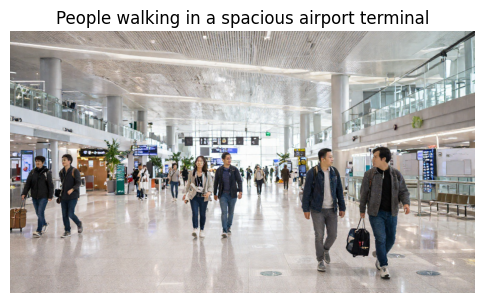

In [8]:
# num_images = 3
# for _ in range(num_images):
#     prompt, img = generate_image(pipeline)
#     display_image(prompt, img)
prompt, img = generate_image(pipeline)
display_image(prompt, img)

In [ ]:
OUTPUT_FOLDER = "generated_images"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
def save_image(prompt, imgs, index):
    filename = f'image_{index}.png'
    full_path = os.path.join(OUTPUT_FOLDER, filename)

    img.save(full_path)
    print(f"Saved: {full_path}")

    # save prompt if needed
    # txt_filename = f"image_{index}.txt"
    # txt_path = os.path.join(OUTPUT_FOLDER, txt_filename)
    # with open(txt_path, "w") as f:
    #     f.write(prompt)


In [ ]:
def generate_images(pipeline, num_images=3):
    num_images = num_images
    for i in range(num_images):
        prompt, img = generate_image(pipeline)
        display_image(prompt, img)
        save_image(img, prompt, i)

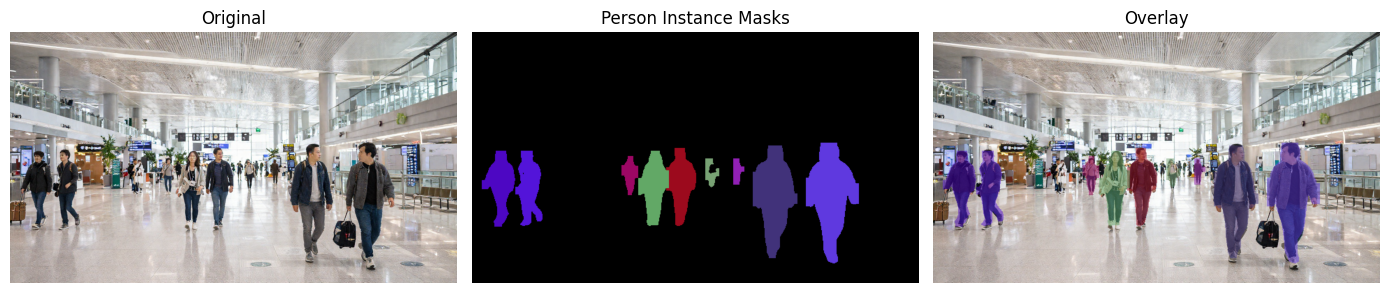

In [9]:
#find people masks

import cv2, numpy as np, matplotlib.pyplot as plt
from ultralytics import YOLO

img_np = np.array(img)
H, W = img_np.shape[:2]

model = YOLO("models/yolo11m-seg.pt")
res = model(img_np, conf=0.65, iou=0.5, verbose=False)[0]

mask_rgb = np.zeros((H, W, 3), dtype=np.uint8)
overlay = img_np.copy()
people = []

for i, cls in enumerate(res.boxes.cls.cpu().numpy()):
    if int(cls) == 0:  # person
        mask_data = res.masks.data[i].cpu().numpy()  # Get the raw mask data (at YOLO's inference resolution)
        resized_mask = cv2.resize(mask_data.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)
        mask = resized_mask.astype(bool)

        color = np.random.randint(0, 256, 3)
        mask_rgb[mask] = color
        overlay[mask] = (0.5 * overlay[mask] + 0.5 * color).astype(np.uint8)
        people.append(res.boxes.xyxy[i].cpu().numpy().astype(int))

plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(mask_rgb)
plt.title("Person Instance Masks")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
import torch
from diffusers import AutoPipelineForInpainting
from PIL import Image
import cv2
import numpy as np
import random

# 1. טעינת מודל Inpainting (אם יש לך GPU חזק, השאר את float16)
pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16"
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


In [ ]:
# פונקציה להחלפת אדם בתיק
def replace_person_with_bag(original_img_np, yolo_result):
    H, W = original_img_np.shape[:2]

    # שליפת האינדקסים של כל האנשים שזוהו
    person_indices = [i for i, cls in enumerate(yolo_result.boxes.cls.cpu().numpy()) if int(cls) == 0]

    if not person_indices:
        print("No people found to replace.")
        return original_img_np

    # בחירת אדם רנדומלי אחד להחלפה
    target_idx = random.choice(person_indices)

    # --- יצירת המסכה לאדם הספציפי הזה ---
    raw_mask = yolo_result.masks.data[target_idx].cpu().numpy()
    resized_mask = cv2.resize(raw_mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

    # *** שלב קריטי: הרחבת המסכה (Dilation) ***
    # זה מונע "הילה" של האדם המקורי מסביב לתיק החדש
    kernel = np.ones((20, 20), np.uint8) # אפשר לשחק עם הגודל בהתאם לרזולוציה
    dilated_mask = cv2.dilate(resized_mask, kernel, iterations=1)

    # המרה לפורמט שהמודל מבין (PIL Image)
    source_image = Image.fromarray(original_img_np)
    mask_image = Image.fromarray(dilated_mask * 255).convert("L") # מסכה בשחור לבן

    # --- הגדרת ה-Prompts ---
    # הטריק: מבקשים תיק על הרצפה, ומציינים שהרקע מעליו ריק
    prompt = "A realistic suspicious black backpack sitting on the floor, empty background above, high quality, 8k"

    # Negative Prompt חזק כדי למנוע יצירת חלקי גוף או מתיחה של התיק
    negative_prompt = "person, man, woman, human, legs, face, arms, standing, tall object, floating object, distorted, blur"

    # --- ג'ינרוט ---
    generator = torch.Generator(device="cuda").manual_seed(random.randint(0, 10000))

    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=source_image,
        mask_image=mask_image,
        guidance_scale=7.5,
        num_inference_steps=30,
        strength=1.0,  # חוזק מקסימלי - למחוק את האדם לגמרי
        generator=generator
    ).images[0]

    return output, mask_image

# --- הרצה (בהנחה ש-img_np ו-res קיימים מהקוד הקודם שלך) ---
final_image, used_mask = replace_person_with_bag(img_np, res)

# --- תצוגה ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(used_mask, cmap='gray')
plt.title("Mask Used (Dilated)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(final_image)
plt.title("Final Result: Suspicious Bag")
plt.axis("off")
plt.show()

  0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
#select random person and inpaint suitacse instead

import random, torch, cv2
from diffusers import StableDiffusionGLIGENPipeline
# from diffusers import ZImageImg2ImgPipeline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np  # Added for np.array

# from diffusers import StableDiffusionXLInpaintPipeline


# ---- choose random person or random place----
x1, y1, x2, y2 = random.choice(people)
pad=50
x1-=pad;x2+=pad;y1-=pad;y2+=pad
# x1,y1,x2,y2=(300,700,450,800) #sample reasonable locations, skip cell above

# ---- GLIGen ----
device = "cuda" if torch.cuda.is_available() else "cpu"
# inpaint_pipe = ZImageImg2ImgPipeline.from_pretrained(
#         "Tongyi-MAI/Z-Image-Turbo", transformer=transformer, torch_dtype=dtype, low_cpu_mem_usage=False
#     ).to(device)


inpaint_pipe = StableDiffusionXLInpaintPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", dtype=torch.bfloat16, device_map=device)


# inpaint_pipe = StableDiffusionGLIGENPipeline.from_pretrained(
#     "masterful/gligen-1-4-inpainting-text-box",  # Corrected model ID
#     torch_dtype=torch.float16).to(device)

prompt = (
    "A photo of a busy supermarket, "
    "indoors, realistic"
)


# prompt = "Supermarket, indoors, photorealistic, a red suitcase"

# out = inpaint_pipe(prompt="A red suitcase", image=img, )

out = inpaint_pipe(
    gligen_scheduled_sampling_beta=1.0,
    output_type="pil", num_inference_steps=60,
    prompt=prompt, gligen_phrases=["a red suitcase"],
    gligen_boxes=[[x1 / W, y1 / H, x2 / W, y2 / H]], guidance_scale=7.5,
    gligen_inpaint_image=Image.fromarray(img_np),  # Ensure img_np is passed as PIL Image
).images[0]

# out = inpaint_pipe(prompt=prompt, image=img, )

out_np = np.array(out)

# ---- display ----
mask_box_vis = mask_rgb.copy()
mask_box_vis = cv2.rectangle(mask_box_vis, (x1, y1), (x2, y2), (255, 0, 0), 3)

#resizew mask to output
H_out, W_out = out_np.shape[:2]
x1o = int((x1 / W) * W_out)
x2o = int((x2 / W) * W_out)
y1o = int((y1 / H) * H_out)
y2o = int((y2 / H) * H_out)
out_np = cv2.rectangle(out_np, (x1o, y1o), (x2o, y2o), (255, 0, 0), 3)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img_np)
plt.title("Original")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(mask_box_vis)
plt.title("Selected Person (red box)")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(out_np)
plt.title("GLIGen Inpainted Red Suitcase")
plt.axis("off")
plt.tight_layout()
plt.show()

NameError: name 'StableDiffusionXLInpaintPipeline' is not defined

In [ ]:
import torch
from diffusers import AutoPipelineForInpainting
from PIL import Image
import cv2
import numpy as np
import random
import gc

# ניקוי זיכרון למקרה שנשאר "זבל" מההרצה הקודמת
gc.collect()
torch.cuda.empty_cache()

# --- טעינת המודל עם התיקון ---
pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16"
).to("cuda")

# !!! התיקון הקריטי: העברת ה-VAE ל-float32 !!!
# זה מונע את התמונה האפורה/שרופה
pipe.vae.to(dtype=torch.float32)

def replace_person_with_bag(original_img_np, yolo_result):
    H, W = original_img_np.shape[:2]

    # מציאת אנשים
    person_indices = [i for i, cls in enumerate(yolo_result.boxes.cls.cpu().numpy()) if int(cls) == 0]

    if not person_indices:
        print("No people found.")
        return original_img_np, np.zeros((H, W), dtype=np.uint8)

    target_idx = random.choice(person_indices)

    # יצירת מסכה
    raw_mask = yolo_result.masks.data[target_idx].cpu().numpy()
    resized_mask = cv2.resize(raw_mask.astype(np.uint8), (W, H), interpolation=cv2.INTER_NEAREST)

    # הרחבה (Dilation) כדי למחוק את האדם לגמרי
    kernel = np.ones((15, 15), np.uint8)
    dilated_mask = cv2.dilate(resized_mask, kernel, iterations=1)

    source_image = Image.fromarray(original_img_np)

    # המרה למסכה: לבן (255) = איפה לשנות, שחור (0) = איפה לשמור
    mask_image = Image.fromarray(dilated_mask * 255).convert("L")

    # פרומפט משופר
    prompt = "A black tactical backpack sitting on the floor, realistic, cinematic lighting, 8k"

    # Negative Prompt חשוב מאוד - אומר למודל מה *לא* לצייר
    negative_prompt = "person, human, legs, shoes, face, ghost, glitch, noise, gray artifacts, distorted"

    generator = torch.Generator(device="cuda").manual_seed(random.randint(0, 10000))

    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=source_image,
        mask_image=mask_image,
        guidance_scale=7.5,
        num_inference_steps=30, # העליתי קצת את מספר הצעדים
        strength=1.0,
        generator=generator
    ).images[0]

    return output, dilated_mask

# --- הרצה מחדש ---
# שים לב: וודא שמשתנה res ו-img_np קיימים מהשלבים הקודמים
try:
    final_image, used_mask = replace_person_with_bag(img_np, res)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(used_mask, cmap='gray')
    plt.title("Mask (White = Replace Area)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(final_image)
    plt.title("Fixed Result")
    plt.axis("off")
    plt.show()
except NameError:
    print("נא להריץ את שלב ה-YOLO שוב כדי להגדיר את img_np ואת res")